<a href="https://colab.research.google.com/github/DurdenTyler2008/University-of-AI/blob/main/19_2_%D0%90%D0%B2%D1%82%D0%BE%D0%BA%D0%BE%D0%B4%D0%B8%D1%80%D0%BE%D0%B2%D1%89%D0%B8%D0%BA%D0%B8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

###Задание:
1. Обучите автокодировщик на 10 выбранных вами красивых цифрах 5 и отредактируйте с помощью него все остальные цифры 5
2. Напишите 3 автокодировщика для подавления шума с собственными архитектурами. Сравните их между собой и с исходным шумоподавляющим атокодировщиком. Сравнивайте по квадрату разности исходной картинки с востановленной из шума
3. Обучите автокодировщик на базе Fashion Mnist, проверьте, как он преобразует картинки одежды, на которых не обучался

In [2]:
from keras.datasets import mnist
from tensorflow.keras.models import Model, Sequential    

from tensorflow.keras.layers import Dense, Flatten, Reshape, Input, Conv2DTranspose, concatenate, Activation, MaxPooling2D, Conv2D, BatchNormalization
from tensorflow.keras import backend as K 
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import utils 
from tensorflow.keras.datasets import mnist, fashion_mnist                     # готовые базы mnist
from tensorflow.keras.callbacks import LambdaCallback

import matplotlib.pyplot as plt 
from tensorflow.keras.preprocessing import image                               # для отрисовки изображения
import numpy as np 
import pandas as pd
from PIL import Image 
from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import StandardScaler 
from IPython.display import Image

import os 
from google.colab import drive 
import time, random
import seaborn as sns
sns.set_style('darkgrid')

In [3]:
drive.mount('/content/drive/') # монтируем google диск

Mounted at /content/drive/


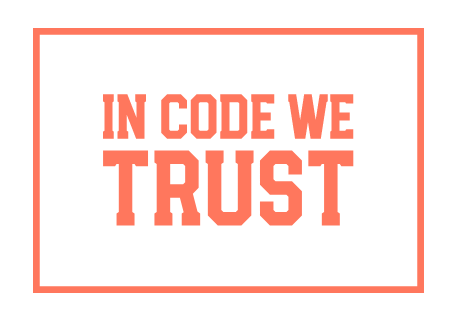

In [4]:
Image("/content/drive/MyDrive/Logo/logo9.png", width=150, height=100)

###1. Обучите автокодировщик на 10 выбранных вами красивых цифрах 5 и отредактируйте с помощью него все остальные цифры 5

In [ ]:
# работаю с базой mnist(загружаю данные и разбиваю:):

In [5]:
(xTrainMnist, yTrainMnist), (xTestMnist, yTestMnist) = mnist.load_data()

11493376/11490434 [==============================] - 0s 0us/step


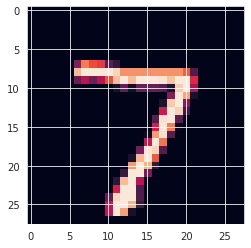

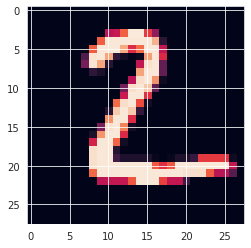

In [6]:
for i in range(2):  
  
  plt.imshow(xTestMnist[i]) 
  plt.show()

In [7]:
print(xTrainMnist.shape, type(xTrainMnist))
print(xTestMnist.shape, type(xTestMnist))
print(yTrainMnist.shape, type(yTrainMnist))
print(yTestMnist.shape, type(yTestMnist))

(60000, 28, 28) <class 'numpy.ndarray'>
(10000, 28, 28) <class 'numpy.ndarray'>
(60000,) <class 'numpy.ndarray'>
(10000,) <class 'numpy.ndarray'>


In [ ]:
# начинаю вычленять из массива изображения числа "5":

In [8]:
train_filter = np.where(yTrainMnist == 5)
test_filter = np.where(yTestMnist == 5)

In [9]:
xTrainMnist, yTrainMnist = xTrainMnist[train_filter], yTrainMnist[train_filter]
xTestMnist, yTestMnist = xTestMnist[test_filter], yTestMnist[test_filter]

In [10]:
print(xTrainMnist.shape, type(xTrainMnist))
print(xTestMnist.shape, type(xTestMnist))
print(yTrainMnist.shape, type(yTrainMnist))
print(yTestMnist.shape, type(yTestMnist))


(5421, 28, 28) <class 'numpy.ndarray'>
(892, 28, 28) <class 'numpy.ndarray'>
(5421,) <class 'numpy.ndarray'>
(892,) <class 'numpy.ndarray'>


In [ ]:
# сначала сделал срез [:10]
# а это индексы "хороших" изображений числа "5"

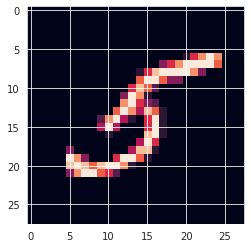

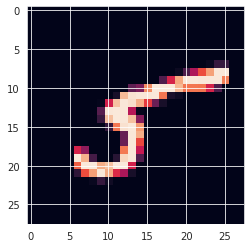

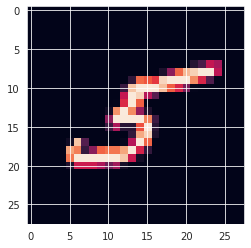

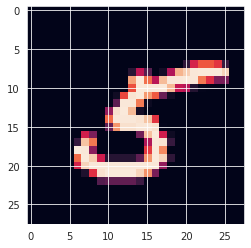

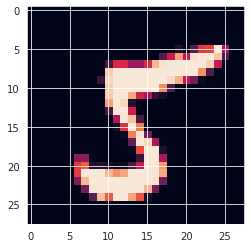

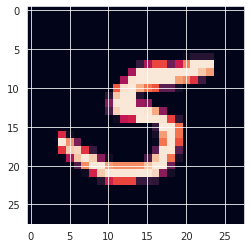

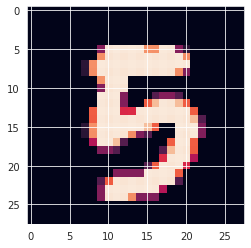

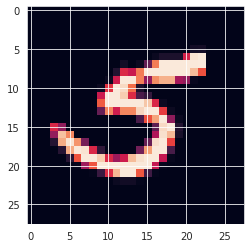

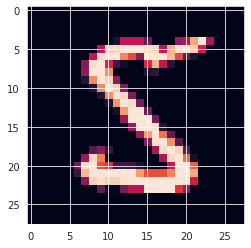

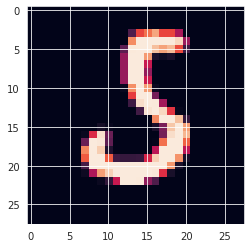

In [11]:
for i in [2,4,9,10,14,15,16,17,18,20]:  
  
  plt.imshow(xTrainMnist[i]) 
  plt.show()

In [12]:
xTrainMnist = xTrainMnist.astype('float32')/255         # в виде значений от 0 до 1
xTrainMnist = xTrainMnist.reshape(-1, 28, 28, 1)        # меняем форму, приводим к нужным нам размерам

xTestMnist = xTestMnist.astype('float32')/255           # в виде значений от 0 до 1
xTestMnist = xTestMnist.reshape(-1, 28, 28, 1)          # меняем форму, приводим к нужным нам размерам

In [13]:
print(xTrainMnist.shape, type(xTrainMnist))
print(xTestMnist.shape, type(xTestMnist))
print(yTrainMnist.shape, type(yTrainMnist))
print(yTestMnist.shape, type(yTestMnist))

(5421, 28, 28, 1) <class 'numpy.ndarray'>
(892, 28, 28, 1) <class 'numpy.ndarray'>
(5421,) <class 'numpy.ndarray'>
(892,) <class 'numpy.ndarray'>


In [14]:
xTrain10 = xTrainMnist[[2,4,9,10,14,15,16,17,18,20]]
xTest10 = xTestMnist[[2,4,9,10,14,15,16,17,18,20]]
yTrain10 = yTrainMnist[[2,4,9,10,14,15,16,17,18,20]]
yTest10 = yTestMnist[[2,4,9,10,14,15,16,17,18,20]]
print(xTrain10.shape)
print(xTest10.shape)
print(yTrain10.shape)
print(yTest10.shape)

(10, 28, 28, 1)
(10, 28, 28, 1)
(10,)
(10,)


In [ ]:
# массив первых 10 изображений цифры "5" готов

In [ ]:
# функция создания базового автокодировщика:

In [86]:
def baseAutoencoder(shape=(112,80,1)):                                      
    img_input = Input((shape)) 

    x = Conv2D(32, (3, 3), padding='same', activation='relu')(img_input) 
    x = BatchNormalization()(x) 
    x = Conv2D(32, (3, 3), padding='same', activation='relu')(x) 
    x = BatchNormalization()(x) 
    x = MaxPooling2D()(x)                                                    # уменьшает размерность поступивших данных(по умолчаниб ы 2 раза)

    x = Conv2D(64, (3, 3), padding='same', activation='relu')(x) 
    x = BatchNormalization()(x)  
    x = Conv2D(64, (3, 3), padding='same', activation='relu')(x)  
    x = BatchNormalization()(x) 
    z = MaxPooling2D()(x)                                                    # уменьшает размерность поступивших данных(по умолчаниб ы 2 раза)

    x = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same', activation='relu')(z)     # слой разжимает данные(с 28*20 на 56*40)
    x = BatchNormalization()(x) 
    
    x = Conv2D(64, (3, 3), padding='same', activation='relu')(x) 
    x = BatchNormalization()(x) 
    x = Conv2D(64, (3, 3), padding='same', activation='relu')(x) 
    x = BatchNormalization()(x)

    x = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same', activation='relu')(x)    # слой разжимает данные(с 56*40 на 112*80)
    x = BatchNormalization()(x) 
    x = Conv2D(32, (3, 3), padding='same', activation='relu')(x) 
    x = BatchNormalization()(x) 
    x = Conv2D(32, (3, 3), padding='same', activation='relu')(x) 
    x = BatchNormalization()(x) 

    x = Conv2D(shape[-1], (3, 3), activation='sigmoid', padding='same')(x)   # Финальный слой двумерной свертки, выдающий итоговое изображение

    model = Model(img_input, x)                                              # img_input - оригинальное изображение на входе; x - сжатое-разжатое на выходе 
    model.compile(optimizer=Adam(lr=0.0001), loss="mean_squared_error")

    return model 

In [ ]:
# функция для вывода изображений как картинок:

In [97]:
def plotImages(xTrain, pred, shape=(112, 80)):       

    n = 10  
    plt.figure(figsize=(14, 7)) 

    for i in range(n): 
          index = np.random.randint(0, pred.shape[0]) # startIndex - начиная с какого индекса хотим заплотить картинки
          
          ax = plt.subplot(2, n, i + 1)               # выведем область рисования Axes
          plt.imshow(xTrain[index].reshape(shape))    # отрисуем правильные картинки в размере 112*80      
          plt.gray()                                  # выведем в черно-белом цвете
          ax.get_xaxis().set_visible(False)           # скрываем вывод координатной оси x
          ax.get_yaxis().set_visible(False)           # скрываем вывод координатной оси y

          ax = plt.subplot(2, n, i + 1 + n)           # выведем область рисования Axes востановленных картинок
          plt.imshow(pred[index].reshape(shape))      # отрисуем обработанные сеткой картинки в размере 112*80     
          plt.gray()
          ax.get_xaxis().set_visible(False)           # скрываем вывод координатной оси x
          ax.get_yaxis().set_visible(False)           # скрываем вывод координатной оси y
          
    plt.show()

In [ ]:
# функция среднеквадратичной ошибки:

In [98]:
def getMSE(x1, x2):                       
    x1 = x1.flatten() 
    x2 = x2.flatten() 
    delta = x1 - x2 
    return sum(delta ** 2) / len(delta)

In [ ]:
# проверка:

In [18]:
x1 = np.array([1, 1, 1]) 
x2 = np.array([1, 1, 2]) 
print("oшибка:", getMSE(x1,x2)) 

oшибка: 0.3333333333333333


In [19]:
modelAutoMnist = baseAutoencoder((28,28,1)) # создаю автокодировщик
modelAutoMnist.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 28, 28, 32)        320       
_________________________________________________________________
batch_normalization (BatchNo (None, 28, 28, 32)        128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 32)        9248      
_________________________________________________________________
batch_normalization_1 (Batch (None, 28, 28, 32)        128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 64)        18496 

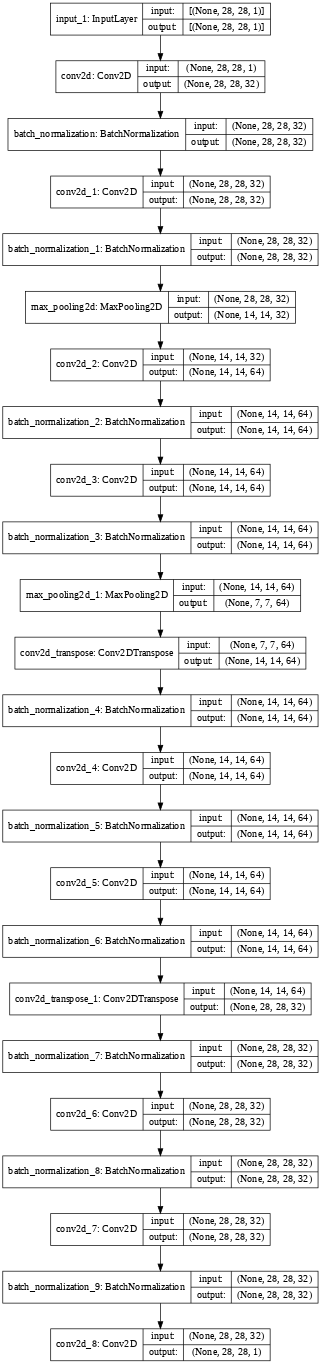

In [20]:
utils.plot_model(modelAutoMnist, dpi=50, show_shapes=True)  # блок-схема автокодировщика

In [ ]:
# обучаю автокодировщика на 10 изображениях цифры "5":

In [42]:
history = modelAutoMnist.fit(xTrain10, xTrain10, epochs=250, batch_size=28, validation_data = (xTest10, xTest10), verbose=0)
print("ошибка на проверочном наборе:", round(history.history["val_loss"][249], 4))

ошибка на проверочном наборе: 0.1037


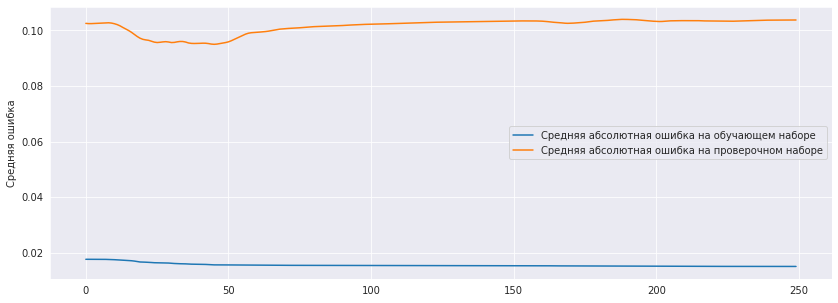

In [43]:
plt.figure(figsize=(14,5))
plt.plot(history.history['loss'], label="Средняя абсолютная ошибка на обучающем наборе")
plt.plot(history.history['val_loss'], label="Средняя абсолютная ошибка на проверочном наборе")
plt.ylabel("Средняя ошибка")
plt.legend()
plt.gray()
plt.show()

In [44]:
modelAutoMnist.save_weights('modelAutoMnist_5.h5') # Сохраняю модель
modelAutoMnist.load_weights('modelAutoMnist_5.h5') # Сохраняю модель

In [45]:
predMnist = modelAutoMnist.predict(xTest10)                 # предикт
predMnist = predMnist * 255                                 # представляем в виде значений от 0 до 255
predMnist = predMnist.astype('uint8')                       # устанавливаем 8битовый тип

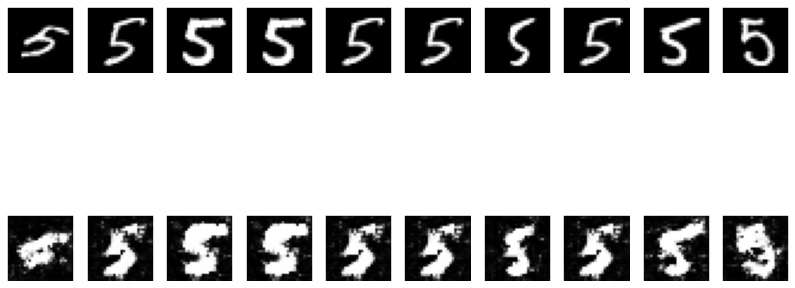

In [46]:
plotImages(xTest10, predMnist, shape=(28,28))               # исходные и восстановленные картинки

In [47]:
err1 = [getMSE(xTrain10[i], predMnist[i] / 255) for i in range(len(predMnist))]  # среднеквадратичная ошибка от правильной картинки и восстановленной
err2 = [getMSE(xTest10[i], predMnist[i] / 255) for i in range(len(predMnist))]   # среднеквадратичная ошибка от правильной картинки и восстановленной
print("Средняя ошибка на обучающем наборе MNIST_5:", round(sum(err1) / xTrain10.shape[0], 4))
print("Средняя ошибка на тестовом наборе MNIST_5:", round(sum(err2) /xTest10.shape[0], 4)) 

Средняя ошибка на обучающем наборе MNIST_5: 0.1615
Средняя ошибка на тестовом наборе MNIST_5: 0.103


####2. Напишите 3 автокодировщика для подавления шума с собственными архитектурами. Сравните их между собой и с исходным шумоподавляющим атокодировщиком. Сравнивайте по квадрату разности исходной картинки с востановленной из шума

In [ ]:
# загружаю базу лиц для зашумления

In [4]:
!unzip -q '/content/drive/My Drive/Лица.zip' 

In [5]:
!ls "/content"

drive  sample_data  Лица


In [6]:
images_dir = "Лица"      # папкa в которую распоковали изображения
img_height = 112         # высота изображений
img_width = 80           # ширина избражений

####функция загрузки изображений, на вход принимает имя папки с изображениями, высоту и ширину к которой будут преобразованы загружаемые изображения

In [7]:
def load_images(images_dir, img_height, img_width):     # функция загрузки изображений

  list_images = [] 
  for img in os.listdir(images_dir):                    # получаю список изображений 
  
     list_images.append(image.img_to_array(image.load_img(os.path.join(images_dir, img), target_size=(img_height, img_width), color_mode='grayscale')))
     # в список изображение в виде массива, с заданными размерами, в отенках серого
  return np.array(list_images) 

In [8]:
cur_time = time.time() 

xTrain_imag = load_images(images_dir, img_height, img_width)    # загружаю лица
print ("Время загрузки:", round(time.time() - cur_time, 3), "sec")

Время загрузки: 31.538 sec


####Нормирую изображения

In [11]:
xTrain_img = xTrain_imag/255           # отнормирую от 0 до 1
xTrain_img.shape

(5018, 112, 80, 1)

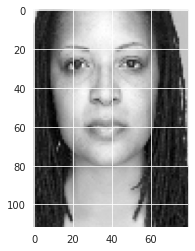

In [12]:
plt.imshow(xTrain_img[np.random.randint(0, xTrain_img.shape[0])].reshape(112,80), cmap='gray') # случайное изображение для проверки
plt.show()

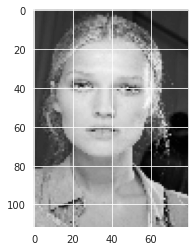

In [13]:
plt.imshow(xTrain_img[np.random.randint(0, xTrain_img.shape[0])].reshape(112,80), cmap='gray') # случайное изображение для проверки
plt.show()

####функция вывода изображений (лица)

In [15]:
def plotImagesFase(xTrain, pred, shape=(112, 80)):       

    n = 7  
    plt.figure(figsize=(14, 7)) 
    for i in range(n): 
          index = np.random.randint(0, pred.shape[0]) # startIndex - начиная с какого индекса хотим заплотить картинки
          
          ax = plt.subplot(2, n, i + 1)               # выведем область рисования Axes
          plt.imshow(xTrain[index].reshape(shape))    # отрисуем правильные картинки в размере 112*80      
          plt.gray()                                  # выведем в черно-белом цвете
          ax.get_xaxis().set_visible(False)           # скрываем вывод координатной оси x
          ax.get_yaxis().set_visible(False)           # скрываем вывод координатной оси y

          ax = plt.subplot(2, n, i + 1 + n)           # выведем область рисования Axes востановленных картинок
          plt.imshow(pred[index].reshape(shape))      # отрисуем обработанные сеткой картинки в размере 112*80     
          plt.gray()
          ax.get_xaxis().set_visible(False)           # скрываем вывод координатной оси x
          ax.get_yaxis().set_visible(False)           # скрываем вывод координатной оси y
    plt.show()

####функция для создания шума

In [16]:
def addNoise(x, noiseVal):                       
    
    noise = np.random.normal(loc=0.5, scale=0.5, size=x.shape)    # шум с центром в 0.5 и отклонением 0.5
    
    # Cкладываю с произведением шума*на усилитель шума и назначаю ограничение значений от 0 до 1(clip)
    return np.clip(x + noiseVal * noise, 0., 1.) 

In [20]:
noisedXTrainFace = addNoise(xTrain_img, 0.09)           # cоздаем зашумленный вариант лиц из xTrain_img

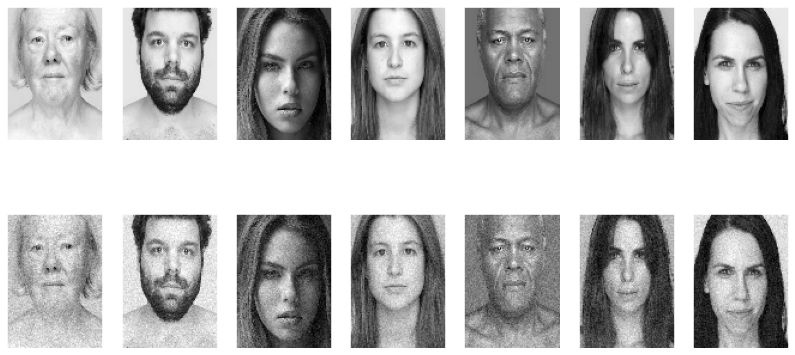

In [21]:
plotImagesFase(xTrain_img, noisedXTrainFace)            # исходные лица и зашумленные варианты noise=0.09

**создаю автокодировщик N1**

In [55]:
img_input = Input((112,80,1)) 

# strides задает длину шага свертки.

x = Conv2D(32, (3, 3), strides=2, activation='relu', padding='same')(img_input)  # уменьшил в 2 раза
x = Conv2D(64, (3, 3), strides=2, activation='relu', padding='same')(x)          # уменьшил в 4 раза
x = Conv2D(128, (3, 3), strides=2, activation='relu', padding='same')(x)         # уменьшил в 8 раза
x = Conv2D(256, (3, 3), strides=2, activation='relu', padding='same')(x)         # уменьшил в 16 раза
x = Flatten()(x)                                                                 # в одномерный вектор - размер 7*5*256=8960

z = Dense(256, activation='relu')(x)

x = Dense(7*5*256, activation='relu')(z)                          # полносвязный слой с переводом в 8960-мерное пространство(7*5*256)
x = Reshape((7,5,256))(x)                                         # меняем размеры - картинка 7*5 , 256 ядер
x = Conv2DTranspose(256, (3, 3), strides=2, padding='same')(x)    # разжимаем картинки из 7*5 до 14*10 (увеличил в 2 раза)
x = Conv2DTranspose(128, (3, 3), strides=2, padding='same')(x)    # разжимаем картинки из 14*10 до 28*20(увеличил в 4 раза)
x = Conv2DTranspose(64, (3, 3), strides=2, padding='same')(x)     # разжимаем картинки из 28*20 до 56*40(увеличил в 8 раз)
x = Conv2DTranspose(32, (3, 3), strides=2, padding='same')(x)     # разжимаем картинки из 56*40 до 112*80(увеличил в 16 раз)

x = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)    

modelN1 = Model(img_input, x)                                     # на вход зашумленные лица на вход, на выходе очищенные от шума 
modelN1.compile(optimizer="adam", loss="mse") 

In [56]:
history = modelN1.fit(noisedXTrainFace[:4700], xTrain_img[:4700], epochs=50, batch_size=50, validation_data = (noisedXTrainFace[4700:], xTrain_img[4700:]), verbose=0)
print("loss на проверочном наборе:", round(history.history["val_loss"][49], 3))

loss на проверочном наборе: 0.006


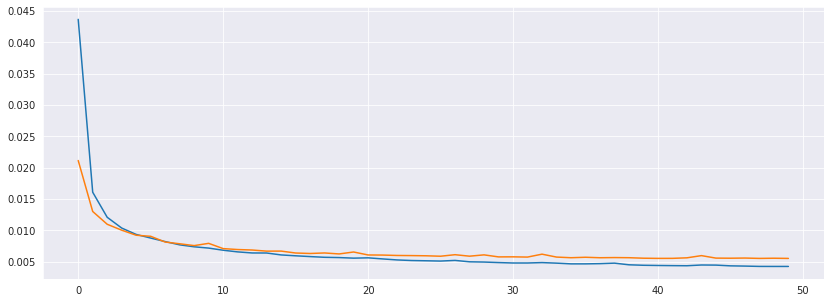

In [57]:
plt.figure(figsize=(14, 5))
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.show()

In [39]:
predFaceDenoise = modelN1.predict(noisedXTrainFace[:4000])               # 4тыс зашумленных картинок и делаем предикт

predFaceDenoise = predFaceDenoise * 255                                  # представляем в виде значений от 0 до 255
predFaceDenoise = predFaceDenoise.astype('uint8')                        # устанавливаем 8битовый тип

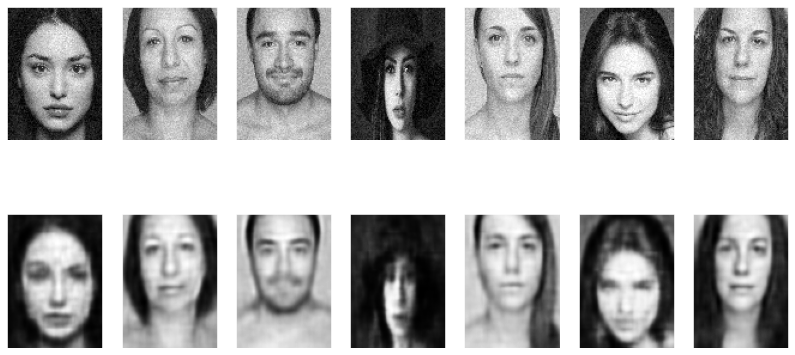

In [40]:
plotImagesFase(noisedXTrainFace, predFaceDenoise)                       # шумоподавление (на входе зашумленные) 

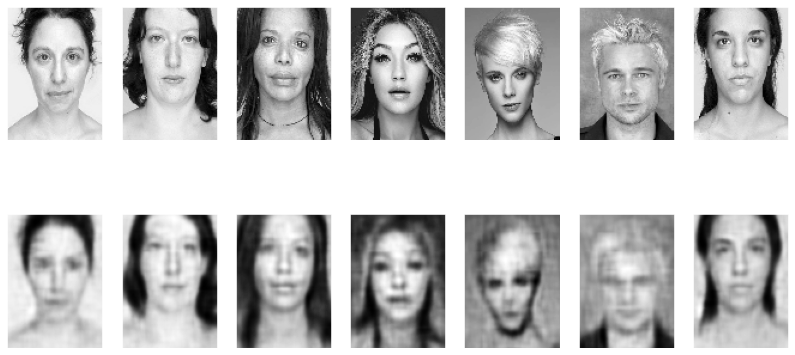

In [42]:
plotImagesFase(xTrain_img, predFaceDenoise)                            # # шумоподавление (на входе исходные)

**создаю автокодировщик N2**

In [65]:
img_input = Input((112,80,1))

x = Conv2D(32, (3, 3), strides=2, activation='relu', padding='same')(img_input)   # уменьшил в 2 раза
x = Conv2D(64, (3, 3), strides=2, activation='relu', padding='same')(x)           # уменьшил в 4 раза
x = Conv2D(128, (3, 3), strides=2, activation='relu', padding='same')(x)          # уменьшил в 8 раз
x = Flatten()(x)                                                                  # вектор - размер 14*10*128=17.920

z = Dense(128, activation='relu')(x)

x = Dense(14*10*128, activation='relu')(z)                                        # полносвязный слой с переводом в 17.920-мерное пространство(14x10x128)
x = Reshape((14,10,128))(x)                                                       # размеры - картинка 14x10 , 128 ядep
x = Conv2DTranspose(128, (3, 3), strides=2, padding='same')(x)                    # разжимаем картинки из 14*10 до 28*20
x = Conv2DTranspose(64, (3, 3), strides=2, padding='same')(x)                     # разжимаем картинки из 28*20 до 56*40
x = Conv2DTranspose(32, (3, 3), strides=2, padding='same')(x)                     # разжимаем картинки из 56*40 до 112*80

x = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)                    # финальный слой двумерной свертки

modelN2 = Model(img_input, x)                                                     # на вход зашумленные лица на вход, на выходе очищенные от шума 
modelN2.compile(optimizer="adam", loss="mse")



In [66]:
history = modelN2.fit(noisedXTrainFace[:4700], xTrain_img[:4700], epochs=50, batch_size=50, validation_data = (noisedXTrainFace[4700:], xTrain_img[4700:]), verbose=0)
print("loss на проверочном наборе:", round(history.history["val_loss"][49], 3))

loss на проверочном наборе: 0.007


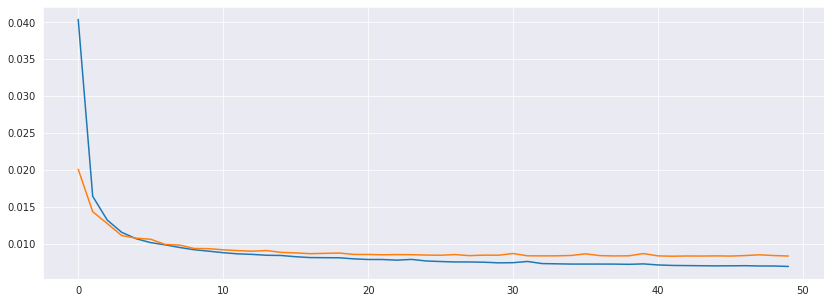

In [60]:
plt.figure(figsize=(14, 5))
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.show()

In [61]:
predFaceDenoise = modelN2.predict(noisedXTrainFace[:4000])               # 4тыс зашумленных картинок и делаем предикт

predFaceDenoise = predFaceDenoise * 255                                  # представляем в виде значений от 0 до 255
predFaceDenoise = predFaceDenoise.astype('uint8')                        # устанавливаем 8битовый тип

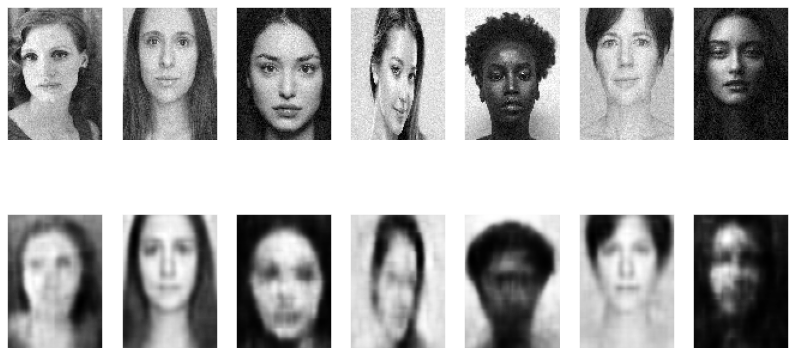

In [62]:
plotImagesFase(noisedXTrainFace, predFaceDenoise)                       # шумоподавление (на входе зашумленные) 

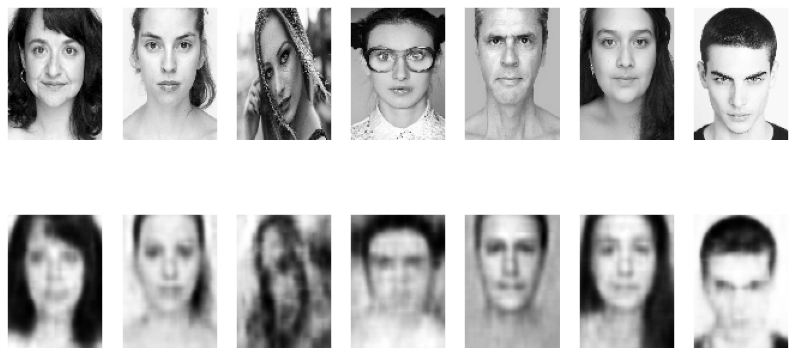

In [63]:
plotImagesFase(xTrain_img, predFaceDenoise)                            # # шумоподавление (на входе исходные)

**создаю автокодировщик N3**

In [67]:
img_input = Input((112,80,1))

x = Conv2D(32, (3, 3), strides=2, activation='relu', padding='same')(img_input)   # уменьшил в 2 раза
x = Conv2D(64, (3, 3), strides=2, activation='relu', padding='same')(x)           # уменьшил в 4 раза
x = Flatten()(x)                                                                  # вектор - размер 28*20*64=35840

z = Dense(64, activation='relu')(x)

x = Dense(28*20*64, activation='relu')(z)                                         # полносвязный слой с переводом в 35840-мерное пространство(28x20x64)
x = Reshape((28,20,64))(x)                                                        # размеры - картинка 14x10 , 64 ядpa
x = Conv2DTranspose(64, (3, 3), strides=2, padding='same')(x)                     # разжимаем картинки из 56*40 до 112*80
x = Conv2DTranspose(32, (3, 3), strides=2, padding='same')(x)                     # разжимаем картинки из 56*40 до 112*80

x = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)    # пропускаем через финальный слой двумерной свертки

modelN3 = Model(img_input, x)                                     # на вход зашумленные лица на вход, на выходе очищенные от шума 
modelN3.compile(optimizer="adam", loss="mse")

In [69]:
history = modelN3.fit(noisedXTrainFace[:4700], xTrain_img[:4700], epochs=50, batch_size=50, validation_data = (noisedXTrainFace[4700:], xTrain_img[4700:]), verbose=0)
print("loss на проверочном наборе:", round(history.history["val_loss"][49], 3))

loss на проверочном наборе: 0.009


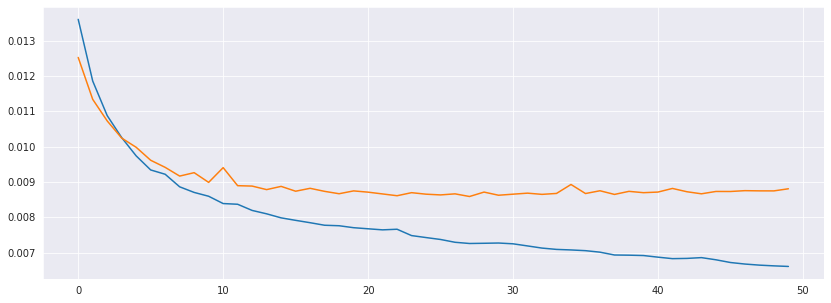

In [70]:
plt.figure(figsize=(14, 5))
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.show()

In [71]:
predFaceDenoise = modelN3.predict(noisedXTrainFace[:4000])               # 4тыс зашумленных картинок и делаем предикт

predFaceDenoise = predFaceDenoise * 255                                  # представляем в виде значений от 0 до 255
predFaceDenoise = predFaceDenoise.astype('uint8')                        # устанавливаем 8битовый тип

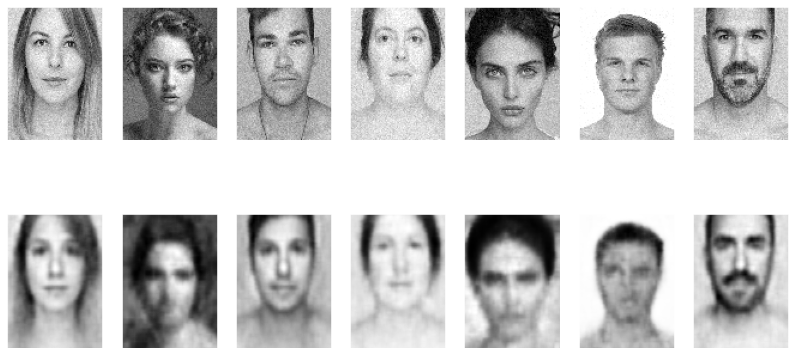

In [72]:
plotImagesFase(noisedXTrainFace, predFaceDenoise)                       # шумоподавление (на входе зашумленные) 

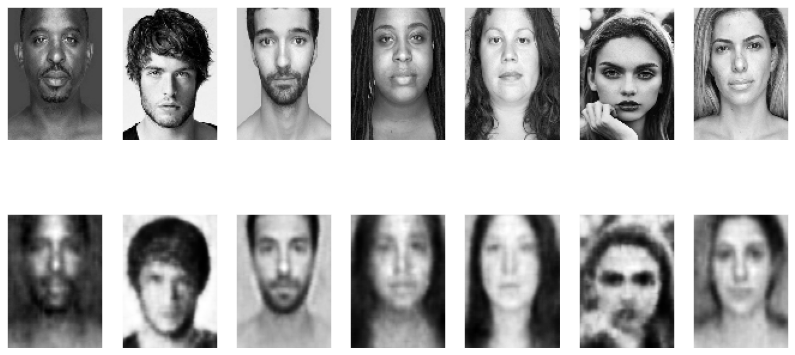

In [73]:
plotImagesFase(xTrain_img, predFaceDenoise)                            # # шумоподавление (на входе исходные)

###**Выводы по заданию №2:** для очищения от шума авокодировщиком, необходимо сжимать входную картинку до максимального значения(пока делится картинка на цело) такой подход даст наилучший результат. В данном случае добавить еще один слой сжатия/разжатия не возможен, т.к. 112х80 не цело на 32 не делится

####3. Обучите автокодировщик на базе Fashion Mnist, проверьте, как он преобразует картинки одежды, на которых не обучался

In [74]:
(xTrainMnistF, yTrainMnistF), (xTestMnistF, yTestMnistF) = fashion_mnist.load_data()  # загоужаю базу fahion
xTrainMnistF = xTrainMnistF.astype('float32')/255                                     # в виде значений от 0 до 1
xTrainMnistF = xTrainMnistF.reshape(xTrainMnistF.shape[0], 28, 28, 1)                 # к размерам 28x28x1

4423680/4422102 [==============================] - 0s 0us/step


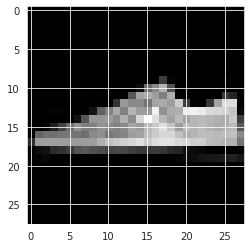

In [80]:
n = 87

xxT = xTrainMnistF[n].reshape((28,28)) 
xxT = xxT * 255 

plt.imshow(xxT, cmap="gray")                                # 4х-канальное цветовое пространство RGBA
plt.show() 

In [81]:
print(xTrainMnistF.shape, type(xTrainMnistF))
print(xTestMnistF.shape, type(xTestMnistF))
print(yTrainMnistF.shape, type(yTrainMnistF))
print(yTestMnistF.shape, type(yTestMnistF))

(60000, 28, 28, 1) <class 'numpy.ndarray'>
(10000, 28, 28) <class 'numpy.ndarray'>
(60000,) <class 'numpy.ndarray'>
(10000,) <class 'numpy.ndarray'>


In [83]:
xTrainMnistF = xTrainMnistF.astype('float32')/255         # в виде значений от 0 до 1
xTrainMnistF = xTrainMnistF.reshape(-1, 28, 28, 1)        # меняем форму, приводим к нужным нам размерам

xTestMnistF = xTestMnistF.astype('float32')/255           # в виде значений от 0 до 1
xTestMnistF = xTestMnistF.reshape(-1, 28, 28, 1)          # меняем форму, приводим к нужным нам размерам

In [84]:
xTrainF = xTrainMnistF[:30000]
xTestF = xTestMnistF[:5000]
yTrainF = yTrainMnistF[:30000]
yTestF = yTestMnistF[:5000]
print(xTrainF.shape)
print(xTestF.shape)
print(yTrainF.shape)
print(yTestF.shape)

(30000, 28, 28, 1)
(5000, 28, 28, 1)
(30000,)
(5000,)


In [87]:
modelFahion = baseAutoencoder((28,28,1))                  # создаю автокодировщик(модель Fashion)

In [90]:
history = modelFahion.fit(xTrainF, xTrainF, epochs=150, batch_size=28, validation_data = (xTestF, xTestF), verbose=0)
print("ошибка на проверочном наборе:", round(history.history["val_loss"][149], 4))

ошибка на проверочном наборе: 0.8665


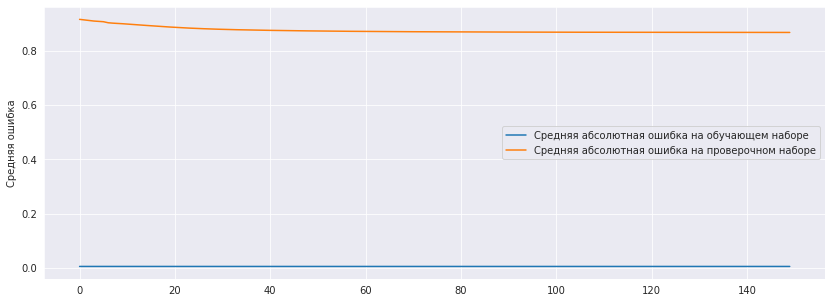

In [91]:
plt.figure(figsize=(14,5))
plt.plot(history.history['loss'], label="Средняя абсолютная ошибка на обучающем наборе")
plt.plot(history.history['val_loss'], label="Средняя абсолютная ошибка на проверочном наборе")
plt.ylabel("Средняя ошибка")
plt.legend()
plt.gray()
plt.show()

In [94]:
modelFahion.save_weights('modelAutoMnist_F.h5') # Сохраняю модель
modelFahion.load_weights('modelAutoMnist_F.h5') # Сохраняю модель

In [95]:
predMnist = modelFahion.predict(xTestF)                    # предикт на половине базы
predMnist = predMnist * 255                                 # представляем в виде значений от 0 до 255
predMnist = predMnist.astype('uint8')                       # устанавливаем 8битовый тип

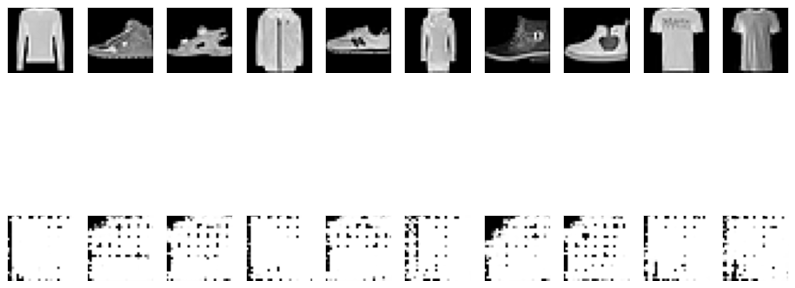

In [99]:
plotImages(xTestMnistF[:5000], predMnist, shape=(28,28))               # исходные и восстановленные моделью, обученной на 1/2 базе fashion

In [100]:
err1 = [getMSE(xTrainF[i], predMnist[i] / 255) for i in range(len(predMnist))]  # среднеквадратичная ошибка от правильной картинки и восстановленной
err2 = [getMSE(xTestF[i], predMnist[i] / 255) for i in range(len(predMnist))]   # среднеквадратичная ошибка от правильной картинки и восстановленной
print("Средняя ошибка на обучающем наборе MNIST_Fashion:", round(sum(err1) / xTrainF.shape[0], 4))
print("Средняя ошибка на тестовом наборе MNIST_Fashion:", round(sum(err2) /xTestF.shape[0], 4))

Средняя ошибка на обучающем наборе MNIST_Fashion: 0.1446
Средняя ошибка на тестовом наборе MNIST_Fashion: 0.8652


###**Вывод задание №3:** обучение модели автокодировщика на 1/2 базе показало очень плохой результат. Нужно учить на всей базе